In [1]:
from __future__ import print_function
import os
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

%matplotlib inline

In [2]:
# Import pdNLS
try:
    # If pdNLS is in PYTHONPATH (or is installed), then use a direct import
    import pdNLS
    #from pdNLS import exponential_decay
    
except ImportError:
    # Attempt to demo pdNLS without installing by importing from directory
    pdNLS_path = '../../pdNLS'
    
    print("Module pdNLS was not found in PYTHONPATH. Looking for module in directory '{:s}'".format(pdNLS_path))
    
    if os.path.exists(pdNLS_path):
        import imp
        pdNLS = imp.load_package('pdNLS', pdNLS_path)
        #exponential_decay = imp.load_package('pdNLS.exponential_decay', pdNLS_path)
        print("Module pdNLS was found in the directory '{:s}' and imported.".format(pdNLS_path))
    else:
        raise ImportError("Module pdNLS could not be found in the directory '{:s}'.".format(pdNLS_path) + \
        "This demonstration will not run until the module is located.")

Module pdNLS was not found in PYTHONPATH. Looking for module in directory '../../pdNLS'
Module pdNLS was found in the directory '../../pdNLS' and imported.


## Overview

`pdNLS` is a library for performing non-linear least squares (NLS) minimization. It attempts to seamlessly incorporate this task in a Pandas-focused workflow. Input data are expected in dataframes, and multiple regressions can be performed using functionality similar to Pandas `groupby`. Results are returned as grouped dataframes and include best-fit parameters, statistics, residuals, and more. The results can be easily visualized using [`seaborn`](https://github.com/mwaskom/seaborn).

`pdNLS` is related to libraries such as [`statsmodels`](http://statsmodels.sourceforge.net) and [`scikit-learn`](http://scikit-learn.org/stable/) that provide linear regression functions that operate on dataframes. As I was unable to find any that perform non-linear regression, I developed `pdNLS` to fill this niche. 

`pdNLS` utilizes [`lmfit`](https://github.com/lmfit/lmfit-py), a flexible and powerful library for non-linear least squares minimization, which in turn, makes use of `scipy.optimize.leastsq`. I began using `lmfit` several years ago because I like the flexibility it offers for testing different modeling scenarios and the variety of assessment statistics it provides. However, I found myself writing many `for` loops to perform regressions on groups of data and aggregate the resulting output.

Some additional 'niceties' associated with the input of parameters and equations have also been incorporated. `pdNLS` also utilizes multithreading for the calculation of confidence intervals, as this process is time consuming when there are more than a few groups.

### Input data

This `pdNLS` demonstration utilizes nuclear magnetic resonance (NMR) data acquired at two different magnetic field strengths (14.1 and 21.1 T) on a protein called GCN4. For the purpose of this demonstration, analyzing this data requires determining the rate of exponential decay as a function of time for every amino acid residue at each of two magnetic field strengths. 

There are 12 amino acids in the enclosed data set, so using amino acid residue (`resi`) and magnetic field (`field`) as the `groupby` columns results in 24 minimization operations.

In [3]:
! head GCN4_twofield.csv

resi	field	time	intensity
45	14.1	0.004	1658.802579
45	14.1	0.008	1501.046724
45	14.1	0.024	906.899665
45	14.1	0.064	394.4461
45	14.1	0.096	191.478005
45	14.1	0.144	67.50144
45	14.1	0.208	9.09046
45	14.1	0.008	1395.774611
45	14.1	0.024	916.524377


In [4]:
data = pd.read_csv('GCN4_twofield.csv', sep='\t')

### Dataframe names

`pdNLS` uses a dataframe for input as well as a column (or list of columns, called `groupbycols` here) for the `groupby` operation prior to fitting. A string input corresponding to the independent data (`xname`) and dependent data (`yname`) are required. Errors for weighting during fitting (`yerr`, not used here) can also be used.

In [5]:
groupbycols = ['resi', 'field']
xname = 'time'
yname = 'intensity'
yerr = None

### Minimization equation

The function format required by `pdNLS` is similar that described in the [`lmfit` documentation](http://lmfit.github.io/lmfit-py/fitting.html#writing-a-fitting-function). Generally speaking, all fit parameters must appear first and they must be contained in a single variable or dictionary that is then unpacked inside the function. The independent (x-) data is next and then the dependent (y-) data.

`pdNLS` contains a separate function that calculates the regression error, so the input function need only calculate the expected value based on input parameters.

Common equations are provided in the `function` module. Currently, an exponential decay and a linear function are provided.

This demo will be using the exponential decay function, whose parameters are:  

$I_{(t)} = I_{(0)} \space e^{(-R * t)}$  

where $I_{(0)}$ is the initial intensity, $I_{(t)}$ is the intensity at time $t$, and $R$ is the exponential decay  rate. 

Here is what the exponential decay function looks like:  

In [6]:
exponential_decay = pdNLS.functions.exponential_decay
print(inspect.getsource(exponential_decay))

def exponential_decay(par, xdata):
    
    # Parse multiple input parameter
    # formats for intensity, rate    
    if hasattr(par,'valuesdict'):
        # lmfit parameter format
        var = par.valuesdict()
        inten = var['inten']
        rate = var['rate']
    elif hasattr(par,'keys'):
        # dict format
        inten = par['inten']
        rate = par['rate']
    else:
        # array/list/tuple format
        inten = par[0]
        rate = par[1]

    # Calculate the y-data from the parameters
    return inten * np.exp(-1*rate*xdata)



### Parameters

Parameters are usually input as a dictionary, although dataframe input will soon be an option. The list of parameters must be the same as the order in which they are unpacked by the minimization function. The keys for each parameter follows the format used by [`lmfit`](). 

Parameter starting values can be a single value or a list. If a single value is entered, it is used for each measurement. If a list or array is entered (see the intensity values below), it must be the same length as the number of groups.

In [7]:
params = [{'name':'inten', 
           'value':np.asarray(data.groupby(groupbycols)[yname].max()), 
           'vary':True},
          {'name':'rate', 
           'value':20.0, 
           'vary':True}]

### Other inputs

The confidence interval(s) (`sigma`) to be calculated can be entered as a single value or a list. The default is 95% (0.95). The number of threads (`threads`) to use for confidence interval calculation will be automatically calculated if not explicitly set.

The only minimization method (`method`) currently supported is Levenberg-Marquardt ('leastsq'). Other methods will be added in the future. 

In [8]:
sigma = 0.95
threads = None
method = 'leastsq'

## Regression and prediction

Performing the regression is quite simple--just call the class `pdNLS` with input parameters set and then use the `fit` method.

In [11]:
fit_data = pdNLS.pdNLS(data, exponential_decay, 
                       groupbycols, params, 
                       xname, yname, 
                       method=method, sigma=sigma,
                       threads=threads)
fit_data.fit()

A best-fit line can be calculated using the `predict` method.

# TODO update when I fix the bug in the predict method

In [12]:
# fit_data.predict()

## Results

`pdNLS` creates four output tables:

* **data** for the input data, calculated data, and residuals
* **results** that contains the best-fit parameters and estimation of their error
* **stats** for statistics related to the regression, such as chi-squared and AIC
* **model** that contains a best-fit line created by the `predict` method

Here is part of the **results** table for a single residue and magnetic field:

# TODO the ycalc and residuals will be added when `predict` is fixed

In [13]:
resi = 50
field = 21.1

fit_data.data.loc[(resi, field)].head(n=10)

time     intensity
resi field                     
50   21.1   0.004  80948.796875
     21.1   0.008  74540.789062
     21.1   0.024  45719.656250
     21.1   0.064  14726.121094
     21.1   0.096   5402.313477
     21.1   0.144   1058.865113
     21.1   0.208    134.102539
     21.1   0.096   6227.864746
     21.1   0.004  80948.796875
     21.1   0.008  74540.789062

The **results** table contains best-fit parameters, their standard errors, and confidence intervals.

In [14]:
fit_data.results.head(n=8)

inten                                 rate            \
                    value       stderr       ci0.95      value    stderr   
resi field                                                                 
45   14.1     1783.891191    12.690847    21.068879  25.841788  0.465950   
     21.1    68538.086731   268.801272   455.113305  30.410723  0.338404   
46   14.1     1761.440245     7.910889    13.303730  22.756338  0.301781   
     21.1    78362.833366   228.132474   421.656856  29.889360  0.325039   
47   14.1     3148.589440     9.954853    16.715550  23.317557  0.263927   
     21.1   127657.522639   438.949013   804.721305  30.642055  0.378902   
48   14.1     1556.181207     4.647944     7.781289  23.882666  0.191555   
     21.1    65935.997539  1912.465747  1909.264571  31.388412  0.963340   

                      
              ci0.95  
resi field            
45   14.1   0.817330  
     21.1   0.591676  
46   14.1   0.551903  
     21.1   0.745799  
47   14.1   0.464269  
     21.1   0.863256  
48   14.1   0.327565  
     21.1   1.486918

The **stats** table contains statistics for each of the regressions:

* Number of observations (`nobs`)
* Number of fit parameters (`npar`)
* Degrees of freedom (`dof`)
* Chi-squared (`chisqr`)
* Reduced chi-squared (`redchi`)
* Akaike information criterion (`aic`)
* Bayesian information criterion (`bic`)
* Covariance matrix (`covar`)

In [15]:
fit_data.stats.head(n=8)

nobs  npar  dof        chisqr        redchi         aic  \
resi field                                                            
45   14.1     22     2   20  8.952754e+07  4.476377e+06  340.915141   
     21.1     16     2   14  6.787742e+12  4.848387e+11  434.513314   
46   14.1     22     2   20  1.791291e+07  8.956455e+05  305.516600   
     21.1     16     2   14  2.519700e+12  1.799786e+11  418.657659   
47   14.1     22     2   20  3.399283e+07  1.699642e+06  319.610417   
     21.1     16     2   14  3.672145e+13  2.622961e+12  461.525197   
48   14.1     22     2   20  1.859047e+06  9.295233e+04  255.676524   
     21.1     16     2   14  1.829944e+14  1.307103e+13  487.222712   

                   bic                                              covar  
resi field                                                                 
45   14.1   343.097226  [[161.057606926, 4.24928458845], [4.2492845884...  
     21.1   436.058491  [[72254.1239277, 62.7516059871], [62.751605987...  
46   14.1   307.698685  [[62.5821690096, 1.55741224293], [1.5574122429...  
     21.1   420.202837  [[52044.4258623, 57.0808005993], [57.080800599...  
47   14.1   321.792502  [[99.0991013849, 1.95159517576], [1.9515951757...  
     21.1   463.070374  [[192676.236024, 127.30158617], [127.30158617,...  
48   14.1   257.858609  [[21.6033798206, 0.610250986648], [0.610250986...  
     21.1   488.767890  [[3657525.23419, 977.119011032], [977.11901103...

It is also easy to access a single covariance matrix for calculations.

In [16]:
fit_data.stats.covar.loc[(resi, field)]

array([[  1.02352178e+05,   9.38106292e+01],
       [  9.38106292e+01,   1.39042861e-01]])

## Visualization

The results are easy to visualize in facet plots with Seaborn. The facet plots will be easier to see if the intensities are normalized first.

In [17]:
fit_itensities = (fit_data.results
                  .loc[:,('inten','value')]
                  .to_frame()
                  )

fit_itensities.columns=['inten_fit']

In [18]:
fit_data.data = pd.merge(fit_data.data,
                         fit_itensities,
                         left_index=True,
                         right_index=True,
                         how='left'
                        )

fit_data.data['intensity'] /= fit_data.data.inten_fit
#fit_data.data['ycalc'] /= fit_data.data.inten_fit

# TODO best-fit lines will be added when `predict` method is fixed.

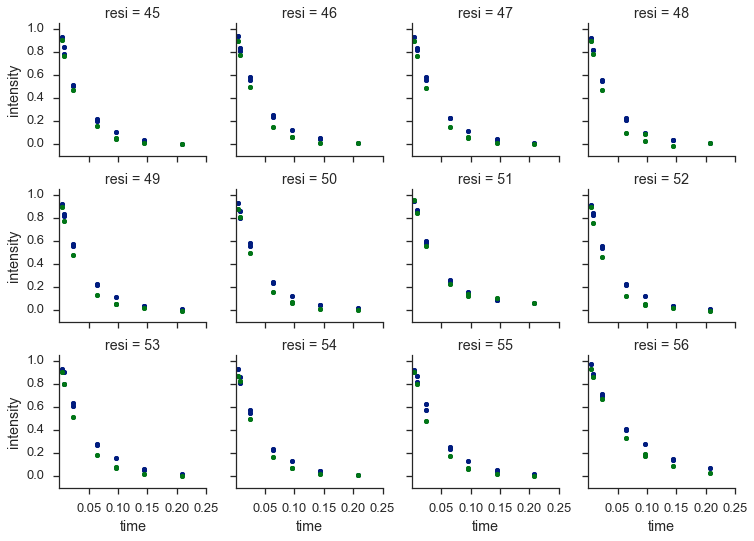

In [19]:
plot_data = fit_data.data.reset_index()

grid = sns.FacetGrid(plot_data, col='resi', hue='field', #palette=palette,
                     col_wrap=4, size=2.0, aspect=0.75, 
                     sharey=True, despine=True)

# grid.map(plt.plot, 'time', 'ycalc', marker='', ls='-')
grid.map(plt.plot, 'time', 'intensity', marker='o', ms=5, ls='')

grid.set(xticks=np.linspace(0.05, 0.25, 5),
         ylim=(-0.1, 1.05))

f = plt.gcf()
f.set_size_inches(12,8)
f.subplots_adjust(wspace=0.2, hspace=0.25)